# Imports

In [ ]:
!pip install transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.9 MB/s eta 0:00:00


# Hugged login

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import XLMRobertaForSequenceClassification, AutoTokenizer
import torch

model_name = "Jayveersinh-Raj/Indo-Aryan-abuse-detection"
tokenizer = AutoTokenizer.from_pretrained("Jayveersinh-Raj/PolyGuard")
model = XLMRobertaForSequenceClassification.from_pretrained(model_name)

# Test data

In [ ]:
import pandas as pd
df = pd.read_csv("/content/encoded_labels_hindi_tweets_test.csv")

In [ ]:
df

,Sentences,encoded_labels
0,के जरिए केन्द्र सरकार दिल्ली के विकास में रोड़...,0
1,बीजेपी को तो कभी मुसलमानो ने अपना माना नहीक्या...,0
2,बी जे पी सरकार मे शिक्षा मित्रो की दुर्गति हो ...,0
3,अब लड़ाई कॉंग्रेस और बीजेपी में नहीं रही अब ल...,0
4,राजस्थान उपचुनाव नतीजे राजस्थान में कांग्रेस ...,0
...,...,...
392,दोस्तों मैं जानती हूँ की इस समय आपका हाथ आपके ...,1
393,कुते वफादार होते हैं पर तुम जैसे सुअर नही होते...,1
394,भेंचो जीजा अपने लण्ड पर क्रांति लिखने में बिजी...,1
395,आज पप्पू और चोदू दोनों साथ साथ होंगे मतलब\t \n,1


In [ ]:
import torch
import time

# Define the device (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move the model to the appropriate device
model = model.to(device)

# Initialize an empty list to store the predictions
predictions = []

# Define the batch size and total time variables
batch_size = 100
total_time = 0.0

# Split the dataframe into batches
for i in range(0, len(df), batch_size):
    batch_texts = df['Sentences'].iloc[i:i+batch_size].tolist()

    # Tokenize the batch of texts and move to the device
    inputs = tokenizer.batch_encode_plus(batch_texts, return_tensors="pt", max_length=512, truncation=True, padding=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Perform the model inference on the batch
    with torch.no_grad():  # Disable gradient calculation during inference
        start_time = time.time()  # Start time for the batch
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        end_time = time.time()  # End time for the batch

    # Calculate the time taken for the batch
    batch_time = end_time - start_time

    # Map predicted class indices to labels
    batch_pred_labels = [1 if pred == 1 else 0 for pred in predicted_classes.tolist()]

    # Extend the predictions list with batch results
    predictions.extend(batch_pred_labels)

    # Accumulate batch time to the total time
    total_time += batch_time

    # Clear variables and tensors that are not required
    del inputs, outputs, probabilities, predicted_classes, batch_texts, batch_pred_labels
    torch.cuda.empty_cache()  # Clear GPU cache if applicable

    # Print time taken for the current batch
    print(f"Batch {i//batch_size+1}: {batch_time:.4f} seconds")

# Assign the predictions to the dataframe
df['pred_lab'] = predictions

# Print total time taken for processing the entire data
print(f"Total time taken for the entire data: {total_time:.4f} seconds")

Batch 1: 0.7837 seconds
Batch 2: 0.0220 seconds
Batch 3: 0.0249 seconds
Batch 4: 0.0128 seconds
Total time taken for the entire data: 0.8434 seconds


In [ ]:
df

,Sentences,encoded_labels,pred_lab
0,के जरिए केन्द्र सरकार दिल्ली के विकास में रोड़...,0,0
1,बीजेपी को तो कभी मुसलमानो ने अपना माना नहीक्या...,0,0
2,बी जे पी सरकार मे शिक्षा मित्रो की दुर्गति हो ...,0,0
3,अब लड़ाई कॉंग्रेस और बीजेपी में नहीं रही अब ल...,0,0
4,राजस्थान उपचुनाव नतीजे राजस्थान में कांग्रेस ...,0,0
...,...,...,...
392,दोस्तों मैं जानती हूँ की इस समय आपका हाथ आपके ...,1,1
393,कुते वफादार होते हैं पर तुम जैसे सुअर नही होते...,1,1
394,भेंचो जीजा अपने लण्ड पर क्रांति लिखने में बिजी...,1,1
395,आज पप्पू और चोदू दोनों साथ साथ होंगे मतलब\t \n,1,1


# Evaluation

In [ ]:
from helper_utils import *

# Confusion matrix

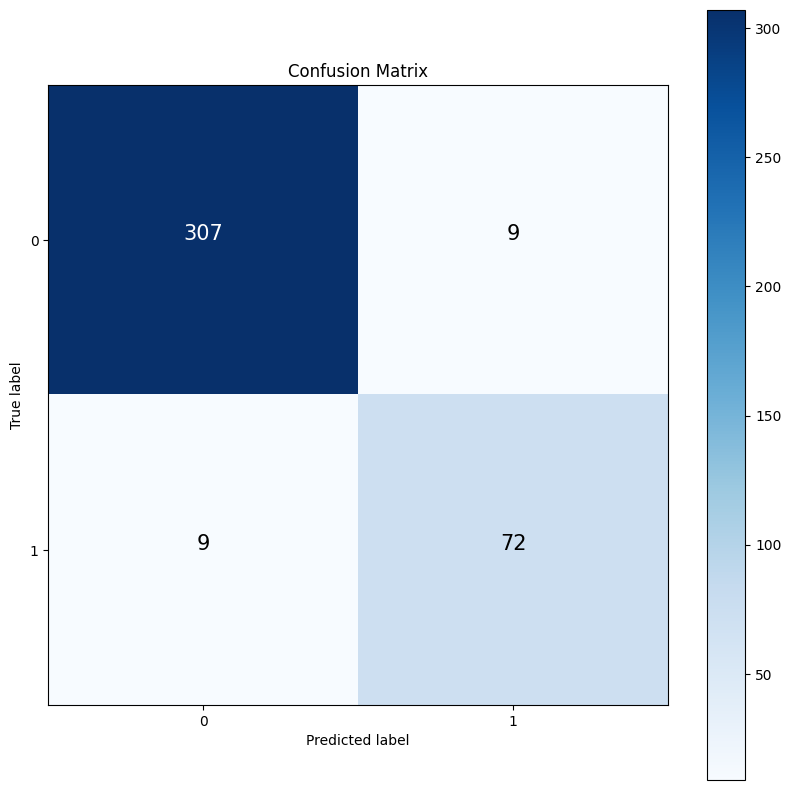

In [ ]:
make_confusion_matrix(y_true = df['encoded_labels'], y_pred = df['pred_lab'])

# Top-1 accuracy

In [ ]:
top_1_accuracy(y_true = df['encoded_labels'], y_pred = df['pred_lab'])

0.9546599496221663

# Precision, Recall, F1

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

precision = precision_score(df['encoded_labels'], df['pred_lab'])
recall = recall_score(df['encoded_labels'], df['pred_lab'])
f1score = f1_score(df['encoded_labels'], df['pred_lab'])

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

Precision = 0.8888888888888888
Recall = 0.8888888888888888
F1 Score = 0.8888888888888888


# Evaluation on Gujarati set

In [11]:
guj_df = pd.read_csv("/content/GujaratiTrainingData.csv")

In [13]:
guj = pd.DataFrame()
guj['tweets'] = guj_df["text"]
guj["labels"] = guj_df["label"]

In [14]:
guj

,tweets,labels
0,@username @username ઇ વાયડાઈ ના તું હાઈસ ડોબો ...,HOF
1,@username @username આવા હલકા કેટલા છે કાય ખબર ...,HOF
2,@username @username તારી જેમ અમે જ્ઞાતિ માં બટ...,HOF
3,@username આવું વાહિયાત ખાવા વાળા લોકો પણ છે 😈😈...,NOT
4,"@username @username બેશક, હું તમને મૂર્ખ કહી શ...",NOT
...,...,...
195,@username આજ વિદેશી પ્રિન્ટ મીડિયા માં રાહુલ ગ...,NOT
196,@username @username @username ભડવો નયન ચાદર મો...,HOF
197,@username ચોદીના તારા જેવા ને પાકિસ્તાન ભેગી ન...,HOF
198,@username @username @username @username @usern...,NOT


# Labels mappings

In [15]:
mappings = {'HOF': 1, 'NOT': 0}

In [18]:
encoded_list = []
for rows in guj["labels"].items():
  encoded_list.append(mappings[rows[1]])

# Adding encodings to the data

In [20]:
guj["encoded_labels"] = encoded_list

In [21]:
guj

,tweets,labels,encoded_labels
0,@username @username ઇ વાયડાઈ ના તું હાઈસ ડોબો ...,HOF,1
1,@username @username આવા હલકા કેટલા છે કાય ખબર ...,HOF,1
2,@username @username તારી જેમ અમે જ્ઞાતિ માં બટ...,HOF,1
3,@username આવું વાહિયાત ખાવા વાળા લોકો પણ છે 😈😈...,NOT,0
4,"@username @username બેશક, હું તમને મૂર્ખ કહી શ...",NOT,0
...,...,...,...
195,@username આજ વિદેશી પ્રિન્ટ મીડિયા માં રાહુલ ગ...,NOT,0
196,@username @username @username ભડવો નયન ચાદર મો...,HOF,1
197,@username ચોદીના તારા જેવા ને પાકિસ્તાન ભેગી ન...,HOF,1
198,@username @username @username @username @usern...,NOT,0


In [22]:
guj.to_csv("gujarati_tweets_encoded.csv", index = False)

In [23]:
view = pd.read_csv("/content/gujarati_tweets_encoded.csv")

In [24]:
view

,tweets,labels,encoded_labels
0,@username @username ઇ વાયડાઈ ના તું હાઈસ ડોબો ...,HOF,1
1,@username @username આવા હલકા કેટલા છે કાય ખબર ...,HOF,1
2,@username @username તારી જેમ અમે જ્ઞાતિ માં બટ...,HOF,1
3,@username આવું વાહિયાત ખાવા વાળા લોકો પણ છે 😈😈...,NOT,0
4,"@username @username બેશક, હું તમને મૂર્ખ કહી શ...",NOT,0
...,...,...,...
195,@username આજ વિદેશી પ્રિન્ટ મીડિયા માં રાહુલ ગ...,NOT,0
196,@username @username @username ભડવો નયન ચાદર મો...,HOF,1
197,@username ચોદીના તારા જેવા ને પાકિસ્તાન ભેગી ન...,HOF,1
198,@username @username @username @username @usern...,NOT,0


# Evaluation

In [28]:
import torch
import time

def infer(df: pd.DataFrame, column: str, model, tokenizer) -> None:
  # Define the device (GPU or CPU)
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  # Move the model to the appropriate device
  model = model.to(device)

  # Initialize an empty list to store the predictions
  predictions = []

  # Define the batch size and total time variables
  batch_size = 100
  total_time = 0.0

  # Split the dataframe into batches
  for i in range(0, len(df), batch_size):
      batch_texts = df[column].iloc[i:i+batch_size].tolist()

      # Tokenize the batch of texts and move to the device
      inputs = tokenizer.batch_encode_plus(batch_texts, return_tensors="pt", max_length=512, truncation=True, padding=True)
      inputs = {key: val.to(device) for key, val in inputs.items()}

      # Perform the model inference on the batch
      with torch.no_grad():  # Disable gradient calculation during inference
          start_time = time.time()  # Start time for the batch
          outputs = model(**inputs)
          probabilities = torch.softmax(outputs.logits, dim=1)
          predicted_classes = torch.argmax(probabilities, dim=1)
          end_time = time.time()  # End time for the batch

      # Calculate the time taken for the batch
      batch_time = end_time - start_time

      # Map predicted class indices to labels
      batch_pred_labels = [1 if pred == 1 else 0 for pred in predicted_classes.tolist()]

      # Extend the predictions list with batch results
      predictions.extend(batch_pred_labels)

      # Accumulate batch time to the total time
      total_time += batch_time

      # Clear variables and tensors that are not required
      del inputs, outputs, probabilities, predicted_classes, batch_texts, batch_pred_labels
      torch.cuda.empty_cache()  # Clear GPU cache if applicable

      # Print time taken for the current batch
      print(f"Batch {i//batch_size+1}: {batch_time:.4f} seconds")

  # Assign the predictions to the dataframe
  df['pred_lab'] = predictions

  # Print total time taken for processing the entire data
  print(f"Total time taken for the entire data: {total_time:.4f} seconds")

In [30]:
infer(df = guj, column = 'tweets', model = model, tokenizer = tokenizer)

Batch 1: 0.0249 seconds
Batch 2: 0.0226 seconds
Total time taken for the entire data: 0.0474 seconds


In [31]:
guj

,tweets,labels,encoded_labels,pred_lab
0,@username @username ઇ વાયડાઈ ના તું હાઈસ ડોબો ...,HOF,1,1
1,@username @username આવા હલકા કેટલા છે કાય ખબર ...,HOF,1,0
2,@username @username તારી જેમ અમે જ્ઞાતિ માં બટ...,HOF,1,1
3,@username આવું વાહિયાત ખાવા વાળા લોકો પણ છે 😈😈...,NOT,0,0
4,"@username @username બેશક, હું તમને મૂર્ખ કહી શ...",NOT,0,1
...,...,...,...,...
195,@username આજ વિદેશી પ્રિન્ટ મીડિયા માં રાહુલ ગ...,NOT,0,0
196,@username @username @username ભડવો નયન ચાદર મો...,HOF,1,1
197,@username ચોદીના તારા જેવા ને પાકિસ્તાન ભેગી ન...,HOF,1,1
198,@username @username @username @username @usern...,NOT,0,0


In [37]:
guj.iloc[1]['tweets']

'@username @username આવા હલકા કેટલા છે કાય ખબર નથી પડતી\nઆવા હલકા વિરોધ કરવા સિવાય બીજો ધંધો જ સુ છે \nજેને બોલાવે તેને એમા તારા બાપા નું સુ જાય છે હલકા \nછાનોમાનો તારું કામ કર ને હલકા હા ત્રેવડ નથી ને સલાહ દેવા આવી ગયો છે હલકો\nભાગ હલકા ભાગ'

# Evaluation

## Confusion Matrix

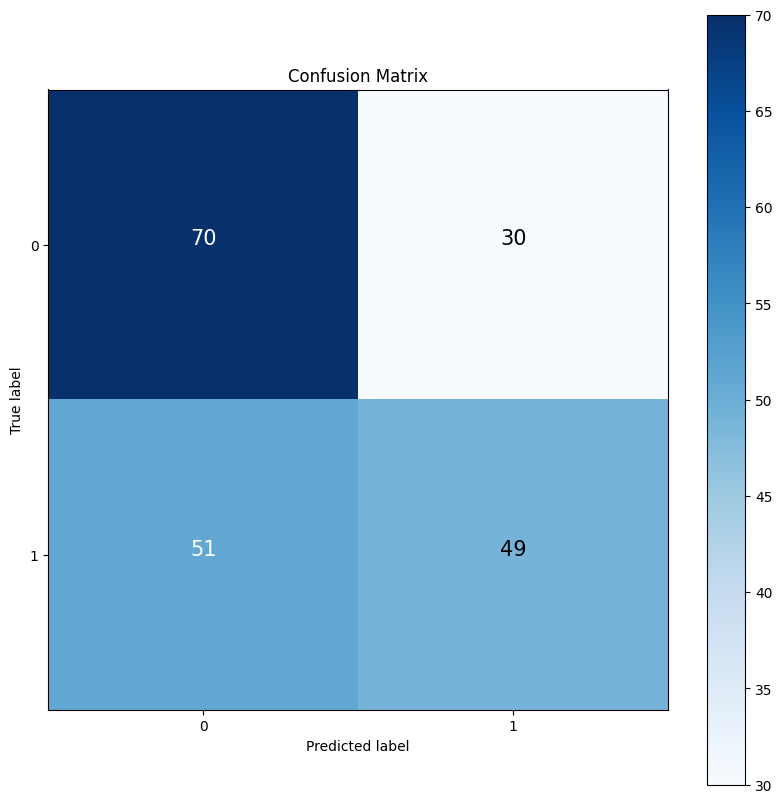

In [33]:
make_confusion_matrix(y_true = guj['encoded_labels'], y_pred = guj['pred_lab'])

# Top-1 accuracy

In [34]:
top_1_accuracy(y_true = guj['encoded_labels'], y_pred = guj['pred_lab'])

0.595

In [35]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

precision = precision_score(guj['encoded_labels'], guj['pred_lab'])
recall = recall_score(guj['encoded_labels'], guj['pred_lab'])
f1score = f1_score(guj['encoded_labels'], guj['pred_lab'])

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

Precision = 0.620253164556962
Recall = 0.49
F1 Score = 0.547486033519553
